
tf.test.gpu_device_name()  
tf.test.is_gpu_available()  

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets,layers,models,optimizers,Sequential,metrics,losses,utils
#from sklearn import preprocessing
import sys,os
print(tf.__version__)
print(sys.version)

2.0.0
3.6.12 |Anaconda, Inc.| (default, Sep  9 2020, 00:29:25) [MSC v.1916 64 bit (AMD64)]


In [70]:
#class_names = ["airplain","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
class_names = ["飛機","汽車","鳥","貓","鹿","狗","青蛙","馬","船","卡車"]
def data_normalize(train, test, scale=1):
    (x_train,y_train) = train
    (x_test,y_test) = test
    train_nums = x_train.shape[0] // scale
    test_nums = x_test.shape[0] // scale
    x_train, y_train = x_train[:train_nums], y_train[:train_nums]
    x_test, y_test = x_test[:train_nums], y_test[:train_nums]
    x_train = x_train.astype(np.float32) / 255.
    x_test = x_test.astype(np.float32) / 255.
    y_train = utils.to_categorical(y_train)#.astype(np.int32)
    y_test = utils.to_categorical(y_test)
    print(x_train.shape,y_train.shape)
    print(x_test.shape,y_test.shape)
    
    return (x_train,y_train),(x_test,y_test)

(x_train,y_train),(x_test,y_test) = datasets.cifar10.load_data()
(x_train,y_train),(x_test,y_test) = data_normalize((x_train,y_train),(x_test,y_test), scale=10)   

(5000, 32, 32, 3) (5000, 10)
(5000, 32, 32, 3) (5000, 10)


In [57]:
class ResBlock(layers.Layer):
    def __init__(self, filter_nums, strides=1):
        super(ResBlock, self).__init__()
        self.conv_1 = layers.Conv2D(filters=filter_nums, kernel_size=3, strides=strides, padding="same")
        self.bn_1 = layers.BatchNormalization()
        self.relu_1 = layers.ReLU()
        self.conv_2 = layers.Conv2D(filters=filter_nums, kernel_size=3, strides=1, padding="same")
        self.bn_2 = layers.BatchNormalization()
        self.relu_2 = layers.ReLU()

        if strides != 1:
            self.block = models.Sequential()            
            self.block.add(layers.Conv2D(filter_nums, kernel_size=1, strides=strides))            
        else:
            self.block = layers.Conv2D(filter_nums, kernel_size=3, padding="same")
            
    def call(self, inputs, training=None):        
        x = self.conv_1(inputs)
        x = self.bn_1(x, training=training)
        x = self.relu_1(x)
        x = self.conv_2(x)
        x = self.bn_2(x, training=training)
        #print("x",x.shape)
        identity = self.block(inputs)
        #print("identity",identity.shape)
        outputs = layers.add([x,identity])
        # outputs = layers.add([x])
        # outputs = x
        outputs = self.relu_2(outputs)
        #print("outputs",outputs.shape)
        return outputs
    
# test_layer = ResBlock(6, strides=3)
# test_layer.build(input_shape=(None,32,32,3))
# test_outputs = test_layer(x_train[0:1])

strides=1  
x (1, 32, 32, 6)  
identity (1, 32, 32, 6)  
outputs (1, 32, 32, 6)  

strides=2  
x (1, 16, 16, 6)  
identity (1, 16, 16, 6)  
outputs (1, 16, 16, 6)  

strides=3  
x (1, 11, 11, 6)  
identity (1, 11, 11, 6)  
outputs (1, 11, 11, 6)  

In [66]:
class ResNet(models.Model):
    def __init__(self, layers_dims, nums_class=10):
        super(ResNet, self).__init__()
        self.model = models.Sequential([layers.Conv2D(128,(3,3),strides=(1,1)),
                             layers.BatchNormalization(),
                             layers.Activation('relu'),
                             layers.MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')]) #filters=32
        
        self.block_1 = self.build_block(64,layers_dims[0]) #filters=64
        self.block_2 = self.build_block(32,layers_dims[1],strides=2) #filters=128
        self.block_3 = self.build_block(16,layers_dims[2],strides=2) #filters=256
        
        self.avg_pool = layers.GlobalAveragePooling2D()                 
        self.fcl = layers.Dense(units=nums_class) 
        
    def call(self, inputs):
        x = self.model(inputs)
        #print("model ops",x.shape)
        x = self.block_1(x)
        #print("block_1 ops",x.shape)
        x = self.block_2(x)  
        #print("block_2 ops",x.shape)
        x = self.block_3(x)        
        #print("block_3 ops",x.shape)
        x = self.avg_pool(x)         
        x = self.fcl(x)    
        #print("block_1 ops",x.shape)
        return x
    
    def build_block(self, filter_nums, block_nums,strides=1):
        block_model = models.Sequential()
        block_model.add(ResBlock(filter_nums, strides))
        for _ in range(1, block_nums):
            block_model.add(ResBlock(filter_nums, strides=1))
        return block_model
    
# test_layer_dims = [2,2,2]        
# test_model = ResNet(test_layer_dims)        
# test_model.build(input_shape=(None,32,32,3))
# print("test_smp",x_train[0:1].shape)
# test_outputs = test_model(x_train[0:1])

layer_dims = [2,2,2]  
model ops (1, 30, 30, 32)  
block_1 ops (1, 30, 30, 64)  
block_2 ops (1, 15, 15, 128)  
block_3 ops (1, 8, 8, 256)  
block_1 ops (1, 10)  

layer_dims = [2,3,4]  
model ops (1, 30, 30, 32)  
block_1 ops (1, 30, 30, 64)  
block_2 ops (1, 15, 15, 128)  
block_3 ops (1, 8, 8, 256)  
block_1 ops (1, 10)  

In [67]:
layer_dims = [2,2,2]        
model = ResNet(test_layer_dims)
model.build(input_shape=(None,32,32,3))
model.summary()

Model: "res_net_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_86 (Sequential)   multiple                  4096      
_________________________________________________________________
sequential_87 (Sequential)   multiple                  296320    
_________________________________________________________________
sequential_88 (Sequential)   multiple                  58048     
_________________________________________________________________
sequential_90 (Sequential)   multiple                  14688     
_________________________________________________________________
global_average_pooling2d_12  multiple                  0         
_________________________________________________________________
dense_12 (Dense)             multiple                  170       
Total params: 373,322
Trainable params: 372,170
Non-trainable params: 1,152
______________________________________________

In [72]:
batch_size = 256
optimizer = optimizers.Adam(lr=0.01)
loss_func = losses.CategoricalCrossentropy(from_logits=True)
model.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy"])
history = model.fit(x_train,y_train, batch_size=batch_size, epochs=6, verbose=1,validation_data=(x_test,y_test))

Train on 5000 samples, validate on 5000 samples
Epoch 1/6
5000/5000 [==============================] - 196s 39ms/sample - loss: 2.3085 - accuracy: 0.1012 - val_loss: 2.3007 - val_accuracy: 0.1084
Epoch 2/6
5000/5000 [==============================] - 185s 37ms/sample - loss: 2.2848 - accuracy: 0.1286 - val_loss: 2.3081 - val_accuracy: 0.1088
Epoch 3/6
5000/5000 [==============================] - 183s 37ms/sample - loss: 2.2611 - accuracy: 0.1400 - val_loss: 2.4463 - val_accuracy: 0.1070
Epoch 4/6
5000/5000 [==============================] - 184s 37ms/sample - loss: 2.2371 - accuracy: 0.1558 - val_loss: 2.2942 - val_accuracy: 0.1060
Epoch 5/6
5000/5000 [==============================] - 186s 37ms/sample - loss: 2.1579 - accuracy: 0.1866 - val_loss: 2.5484 - val_accuracy: 0.1510
Epoch 6/6
5000/5000 [==============================] - 189s 38ms/sample - loss: 2.0197 - accuracy: 0.2340 - val_loss: 2.1773 - val_accuracy: 0.1496


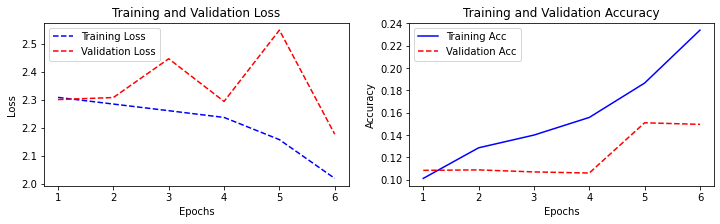

In [73]:
def visual_train_status(history):
        plt.figure(figsize=(12,3))
        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        epochs = range(1, len(loss)+1)  
        plt.subplot(1,2,1)
        plt.plot(epochs, loss, "b--", label="Training Loss")
        plt.plot(epochs, val_loss, "r--", label="Validation Loss")
        plt.title("Training and Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        
        # 顯示訓練和驗證準確度
        acc = history.history["accuracy"]
        val_acc = history.history["val_accuracy"]
        epochs = range(1, len(acc)+1)
        plt.subplot(1,2,2)
        plt.plot(epochs, acc, "b-", label="Training Acc")
        plt.plot(epochs, val_acc, "r--", label="Validation Acc")
        plt.title("Training and Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
        
visual_train_status(history)

In [81]:
# save_dir = os.path.join(".","model")
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)   
# filename = "ResNet.h5"    
# filepath = os.path.join(save_dir,filename)
# model.save(filepath)
# print(filepath,"saved")

NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model.

Predictions
tf.Tensor([4 7 4 4 7 7 4 4 7 4], shape=(10,), dtype=int64)
Labels
tf.Tensor([4 5 6 3 1 1 3 6 8 7], shape=(10,), dtype=int64)
鹿	狗	青蛙	貓	汽車	汽車	貓	青蛙	船	馬	


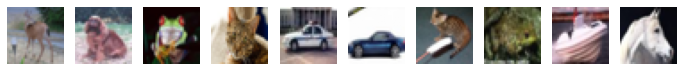

In [85]:
index = 100 # np.random.randint(900)
preds = model.predict(x_test[index:index+10])
preds = tf.argmax(preds, axis=1)
print("Predictions")
print(preds)
labels = y_test[index:index+10]
labels = tf.argmax(labels, axis=1)
print("Labels")
print(labels)
for i in range(10):
    print(class_names[labels[i]],end="\t")
print()
plt.figure(figsize=(12,2))
for i in range(10):
    plt.subplot(1,10,(i+1))
    plt.axis("off")
    plt.imshow(x_test[index+i])
plt.show()